In [1]:
%matplotlib inline
%mkdir figures
from load_data import load_abalone, load_heart_disease, load_diabetes
from datetime import datetime
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt


seed = 1
np.random.seed(seed)
test_ratios = np.arange(20) / 50 + 0.05 # from 0.05 to .6 
test_ratio = .2

dset = "heart"
x, y = load_heart_disease()
x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=test_ratio, stratify=y, random_state=seed)
split_presets = [train_test_split(x, y, test_size=ratio, stratify=y, random_state=seed) for ratio in test_ratios]
num_iter_cv = 20
split_presets_all = [[train_test_split(x, y, test_size=ratio, stratify=y, random_state=seeding) for ratio in test_ratios] for seeding in range(num_iter_cv)]
# Because folding isn't possible over random ratios, simply run split_presets 5 times
# Other visualization notes: confusion matrix
# 60 20 20 best split
# Consider oversampling/undersampling to balance bias: https://www.datascience.com/blog/imbalanced-data
def r_err(y_te, y_pred): # return error
    return round(1 - accuracy_score(y_te, y_pred), 3)

mkdir: cannot create directory ‘figures’: File exists


In [2]:
# Hyperparameters
validation_splits = 5
kf = KFold(n_splits=validation_splits)
print("Train KFold k={}".format(validation_splits))

Train KFold k=5


In [3]:
# Decision Tree: https://scikit-learn.org/stable/modules/tree.html
# Pruning: https://stackoverflow.com/questions/49428469/pruning-decision-trees
from sklearn.tree import DecisionTreeClassifier, export_graphviz
clf = DecisionTreeClassifier(random_state=seed, max_depth=7)
accuracy = cross_val_score(clf, x_tr, y_tr, scoring='accuracy', cv=kf)
print(accuracy.mean()) # Easy graph over number of classes here
time_start = datetime.now()
clf = clf.fit(x_tr, y_tr)
print("Decision tree trained in {}".format(datetime.now() - time_start))
y_pred = clf.predict(x_te)
print(accuracy_score(y_te, y_pred))

0.7677721088435374
Decision tree trained in 0:00:00.001170
0.7049180327868853


In [4]:
dt_hyperparams = {"criterion": ["gini", "entropy"],
                  "max_depth": range(1, 30),
                  "max_leaf_nodes": range(10, 100),
                  "min_weight_fraction": np.arange(20) * 0.01}
dt_results = {}

for key in dt_hyperparams:
    dt_results[key] = []
    dt_results["tr_{}".format(key)] = []
dt_results["tr_size"] = []
dt_results["tr_tr_size"] = []

In [5]:
dt_results["tr_size"] = []
dt_results["tr_tr_size"] = []
clf = DecisionTreeClassifier(max_depth=10, random_state=seed)
for splits in split_presets:
    split_x_tr, split_x_te, split_y_tr, split_y_te = splits
    clf = clf.fit(split_x_tr, split_y_tr)
    y_pred = clf.predict(split_x_te)
    dt_results["tr_size"].append(r_err(split_y_te, y_pred))
    y_tr_pred = clf.predict(split_x_tr)
    dt_results["tr_tr_size"].append(r_err(split_y_tr, y_tr_pred))
print(dt_results["tr_tr_size"])

[0.01, 0.004, 0.007, 0.004, 0.0, 0.004, 0.0, 0.0, 0.0, 0.022, 0.0, 0.005, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [6]:
dt_results["criterion"] = []
dt_results["tr_criterion"] = []
for crit in dt_hyperparams["criterion"]:
    clf = DecisionTreeClassifier(criterion=crit, max_depth=10)
    accuracy = cross_val_score(clf, x_tr, y_tr, scoring='accuracy', cv=kf)
    print(accuracy.mean()) # Easy graph over number of classes here
    
    clf = clf.fit(x_tr, y_tr)
    y_pred = clf.predict(x_te)
    dt_results["criterion"].append(r_err(y_te, y_pred))
    y_tr_pred = clf.predict(x_tr)
    dt_results["tr_criterion"].append(r_err(y_tr, y_tr_pred))
print(dt_results["criterion"])

0.784438775510204
0.7471088435374149
[0.262, 0.295]


In [7]:
dt_results["max_depth"] = []
dt_results["tr_max_depth"] = []
for depth in dt_hyperparams["max_depth"]:
    clf = DecisionTreeClassifier(max_depth=depth)
    clf = clf.fit(x_tr, y_tr)
    y_pred = clf.predict(x_te)
    dt_results["max_depth"].append(r_err(y_te, y_pred))
    y_tr_pred = clf.predict(x_tr)
    dt_results["tr_max_depth"].append(r_err(y_tr, y_tr_pred))
print(dt_results["max_depth"])

[0.295, 0.295, 0.23, 0.23, 0.213, 0.262, 0.279, 0.279, 0.246, 0.262, 0.279, 0.295, 0.246, 0.262, 0.246, 0.295, 0.262, 0.262, 0.262, 0.279, 0.246, 0.262, 0.262, 0.279, 0.23, 0.279, 0.262, 0.23, 0.279]


In [8]:
dt_results["tr_max_leaf_nodes"] = []
dt_results["max_leaf_nodes"] = []
for mln in dt_hyperparams["max_leaf_nodes"]:
    clf = DecisionTreeClassifier(max_depth=10, max_leaf_nodes=mln)
    clf = clf.fit(x_tr, y_tr)
    y_pred = clf.predict(x_te)
    dt_results["max_leaf_nodes"].append(r_err(y_te, y_pred))
    y_tr_pred = clf.predict(x_tr)
    dt_results["tr_max_leaf_nodes"].append(r_err(y_tr, y_tr_pred))
print(dt_results["max_leaf_nodes"])

[0.213, 0.246, 0.23, 0.246, 0.246, 0.213, 0.213, 0.213, 0.213, 0.23, 0.213, 0.262, 0.262, 0.246, 0.246, 0.246, 0.246, 0.23, 0.23, 0.213, 0.262, 0.18, 0.246, 0.262, 0.262, 0.279, 0.279, 0.246, 0.246, 0.246, 0.279, 0.262, 0.295, 0.213, 0.197, 0.246, 0.311, 0.262, 0.295, 0.262, 0.246, 0.246, 0.262, 0.279, 0.295, 0.279, 0.246, 0.246, 0.23, 0.262, 0.311, 0.262, 0.279, 0.279, 0.262, 0.246, 0.279, 0.262, 0.295, 0.262, 0.279, 0.262, 0.262, 0.23, 0.295, 0.246, 0.262, 0.295, 0.295, 0.295, 0.262, 0.295, 0.295, 0.279, 0.279, 0.311, 0.262, 0.262, 0.295, 0.246, 0.295, 0.262, 0.246, 0.295, 0.262, 0.295, 0.246, 0.295, 0.279, 0.246]


In [9]:
dt_results["min_weight_fraction"] = []
dt_results["tr_min_weight_fraction"] = []
for frac in dt_hyperparams["min_weight_fraction"]:
    clf = DecisionTreeClassifier(max_depth=10, min_weight_fraction_leaf=frac)
    clf = clf.fit(x_tr, y_tr)
    y_pred = clf.predict(x_te)
    dt_results["min_weight_fraction"].append(r_err(y_te, y_pred))
    y_tr_pred = clf.predict(x_tr)
    dt_results["tr_min_weight_fraction"].append(r_err(y_tr, y_tr_pred))
print(dt_results["min_weight_fraction"])

[0.246, 0.23, 0.295, 0.246, 0.23, 0.213, 0.262, 0.23, 0.23, 0.279, 0.246, 0.246, 0.246, 0.197, 0.262, 0.246, 0.246, 0.279, 0.279, 0.279]


In [10]:
# import graphviz 
# dot_data = export_graphviz(clf, out_file=None) 
# graph = graphviz.Source(dot_data) 
# graph.render("abalone") 
# graph.view()

In [11]:
# Neural Net: https://scikit-learn.org/stable/modules/neural_networks_supervised.html
# Sample sanity run
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-3,
                     hidden_layer_sizes=(10, 10), random_state=seed)
accuracy = cross_val_score(clf, x_tr, y_tr, scoring='accuracy', cv=kf)
print(accuracy.mean()) # Easy graph over number of classes here
time_start = datetime.now()
clf = clf.fit(x_tr, y_tr)
print("Neural net trained in {}".format(datetime.now() - time_start))
y_pred = clf.predict(x_te)
print(accuracy_score(y_te, y_pred))

0.805017006802721
Neural net trained in 0:00:00.053002
0.7868852459016393


In [12]:
# Neural net hyperparams
from sklearn.utils.extmath import cartesian
net_hyperparams = {"activation": ['identity','relu', 'logistic', 'tanh'],
               "epochs": np.arange(200) + 1, # iterations - when testing iterations set tol to 1e-8 or something
               "arch1": [()] + [(i) for i in (np.arange(100) + 1)],
               "arch2": cartesian((np.arange(1, 21), np.arange(1, 21))), # 2d plane search - reshape 20x20x2 for graph
               "arch3": [[10] * i for i in range(3, 10)], # Deeper architectures with 10 per layer
               "alpha": (np.arange(100) + 1) * 1e-5} # 1e-5 -> 1e-3
# Base params: relu, max_iter: 200 (==> convergence), lbfgs (good for smaller datasets), standard alpha
net_results = {}

for key in net_hyperparams:
    net_results[key] = []
    net_results["tr_{}".format(key)] = []


In [13]:
net_results["tr_size"] = []
net_results["tr_tr_size"] = []
clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(10, 10), random_state=seed)
for splits in split_presets:
    split_x_tr, split_x_te, split_y_tr, split_y_te = splits
    clf = clf.fit(split_x_tr, split_y_tr)
    y_pred = clf.predict(split_x_te)
    net_results["tr_size"].append(r_err(split_y_te, y_pred))
    y_tr_pred = clf.predict(split_x_tr)
    net_results["tr_tr_size"].append(r_err(split_y_tr, y_tr_pred))
print(net_results["tr_size"])

[0.25, 0.182, 0.179, 0.235, 0.175, 0.196, 0.154, 0.207, 0.234, 0.243, 0.303, 0.268, 0.193, 0.223, 0.2, 0.245, 0.214, 0.229, 0.194, 0.208]


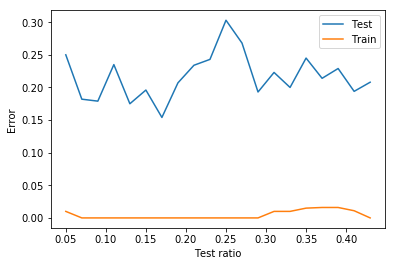

In [14]:
plt.plot(test_ratios, net_results["tr_size"], label="Test")
plt.plot(test_ratios, net_results["tr_tr_size"], label="Train")
plt.legend()
plt.ylabel("Error")
plt.xlabel("Test ratio")
plt.savefig("net_tr_size.png")

In [15]:
for act in net_hyperparams["activation"]:
    clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(10, 10), activation=act, random_state=seed)
    clf = clf.fit(x_tr, y_tr)
    y_pred = clf.predict(x_te)
    net_results["activation"].append(r_err(y_te, y_pred))
    y_tr_pred = clf.predict(x_tr)
    net_results["tr_activation"].append(r_err(y_tr, y_tr_pred))
print(net_results["activation"])


[0.18, 0.197, 0.213, 0.197]


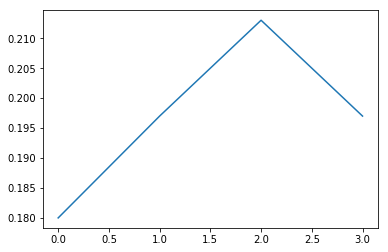

In [16]:
plt.plot(np.arange(len(net_hyperparams["activation"])), net_results["activation"])

In [17]:
net_results["epochs_time"] = []
for ep in net_hyperparams["epochs"]:
    clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(10, 10), max_iter=ep, tol=1e-10, random_state=seed)
    time_start = datetime.now()
    clf = clf.fit(x_tr, y_tr)
    time_elapsed = (datetime.now() - time_start).microseconds
    y_pred = clf.predict(x_te)    
    net_results["epochs"].append(r_err(y_te, y_pred))
    net_results["epochs_time"].append(round(time_elapsed, 3))
    y_tr_pred = clf.predict(x_tr)
    net_results["tr_epochs"].append(r_err(y_tr, y_tr_pred))
net_results["epochs_time"] = np.asarray(net_results["epochs_time"]) * 1e-3 # Microseconds -> ms

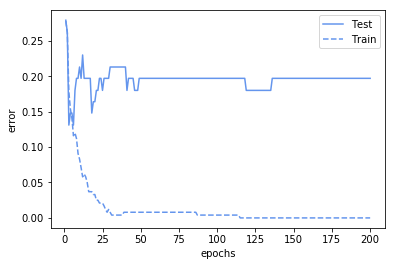

In [18]:
# Monkey patch graphs
plt.plot(net_hyperparams["epochs"], net_results["epochs"], color="cornflowerblue", linestyle='-', label="Test")
plt.plot(net_hyperparams["epochs"], net_results["tr_epochs"], color="cornflowerblue", linestyle='--', label="Train")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("error")
plt.savefig("figures/heart_net_epochs.png")

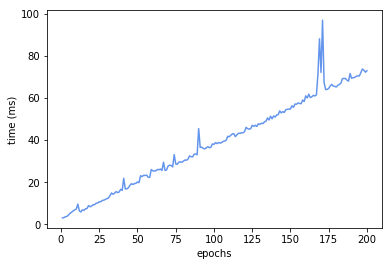

In [19]:
# Monkey patch graphs
plt.plot(net_hyperparams["epochs"], net_results["epochs_time"], color="cornflowerblue", linestyle='-')
plt.xlabel("epochs")
plt.ylabel("time (ms)")
plt.savefig("figures/heart_net_epochs_time.png")

In [20]:
for a in net_hyperparams["alpha"]:
    clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(10, 10), alpha=a, random_state=seed)
    clf = clf.fit(x_tr, y_tr)
    y_pred = clf.predict(x_te)
    net_results["alpha"].append(r_err(y_te, y_pred))
    y_tr_pred = clf.predict(x_tr)
    net_results["tr_alpha"].append(r_err(y_tr, y_tr_pred))
print(net_results["alpha"])

[0.23, 0.23, 0.23, 0.23, 0.23, 0.18, 0.213, 0.197, 0.197, 0.197, 0.213, 0.23, 0.213, 0.213, 0.18, 0.23, 0.213, 0.23, 0.213, 0.23, 0.213, 0.23, 0.23, 0.197, 0.18, 0.23, 0.23, 0.18, 0.18, 0.197, 0.18, 0.18, 0.213, 0.197, 0.197, 0.197, 0.18, 0.246, 0.262, 0.23, 0.23, 0.23, 0.246, 0.246, 0.23, 0.23, 0.213, 0.246, 0.23, 0.213, 0.23, 0.213, 0.23, 0.246, 0.213, 0.246, 0.197, 0.197, 0.213, 0.246, 0.23, 0.213, 0.213, 0.246, 0.197, 0.197, 0.213, 0.23, 0.213, 0.23, 0.23, 0.23, 0.23, 0.23, 0.23, 0.23, 0.213, 0.23, 0.213, 0.213, 0.197, 0.213, 0.213, 0.197, 0.213, 0.213, 0.213, 0.213, 0.213, 0.23, 0.213, 0.197, 0.23, 0.23, 0.213, 0.23, 0.18, 0.197, 0.197, 0.213]


In [21]:
arches = ["arch1", "arch2", "arch3"]
for arch_name in arches:
    for arch in net_hyperparams[arch_name]:
        clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=arch, random_state=seed)
        clf = clf.fit(x_tr, y_tr)
        y_pred = clf.predict(x_te)
        net_results[arch_name].append(r_err(y_te, y_pred))
        y_tr_pred = clf.predict(x_tr)
        net_results["tr_{}".format(arch_name)].append(r_err(y_tr, y_tr_pred))

print(net_results["arch1"], net_results["arch2"], net_results["arch3"])

[0.18, 0.18, 0.197, 0.18, 0.213, 0.262, 0.23, 0.148, 0.213, 0.262, 0.23, 0.23, 0.18, 0.197, 0.23, 0.246, 0.23, 0.295, 0.197, 0.197, 0.23, 0.213, 0.197, 0.213, 0.213, 0.18, 0.18, 0.262, 0.213, 0.213, 0.197, 0.23, 0.213, 0.18, 0.23, 0.18, 0.262, 0.262, 0.23, 0.148, 0.197, 0.246, 0.197, 0.213, 0.213, 0.213, 0.262, 0.213, 0.18, 0.213, 0.23, 0.23, 0.18, 0.197, 0.164, 0.246, 0.18, 0.262, 0.148, 0.148, 0.197, 0.23, 0.213, 0.197, 0.213, 0.18, 0.148, 0.18, 0.18, 0.197, 0.23, 0.23, 0.148, 0.197, 0.23, 0.23, 0.18, 0.246, 0.23, 0.164, 0.197, 0.262, 0.197, 0.164, 0.213, 0.18, 0.197, 0.246, 0.18, 0.18, 0.164, 0.164, 0.18, 0.148, 0.18, 0.164, 0.131, 0.18, 0.18, 0.213, 0.18] [0.164, 0.18, 0.279, 0.148, 0.213, 0.148, 0.18, 0.148, 0.18, 0.197, 0.18, 0.164, 0.18, 0.18, 0.148, 0.197, 0.164, 0.197, 0.148, 0.18, 0.279, 0.197, 0.18, 0.213, 0.164, 0.213, 0.18, 0.18, 0.131, 0.18, 0.23, 0.18, 0.164, 0.213, 0.164, 0.18, 0.213, 0.148, 0.197, 0.148, 0.18, 0.197, 0.148, 0.213, 0.148, 0.18, 0.213, 0.164, 0.197, 0.14

In [22]:
# Boosting (Adaboost): https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1, random_state=seed), random_state=seed)

accuracy = cross_val_score(clf, x_tr, y_tr, scoring='accuracy', cv=kf)
print(accuracy.mean()) # Easy graph over number of classes here
time_start = datetime.now()
clf = clf.fit(x_tr, y_tr)
print("AdaBoosted classifier trained in {}".format(datetime.now() - time_start))
y_pred = clf.predict(x_te)
y_pred = clf.predict(x_te)
print(accuracy_score(y_te, y_pred))


/home/joel/anaconda2/envs/pyEnv/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


0.813265306122449
AdaBoosted classifier trained in 0:00:00.053939
0.6885245901639344


In [23]:
from sklearn.linear_model import SGDClassifier
base_classifiers = ["DT",
                    "Log Loss SGD",
                    "Hinge Loss SGD"]
base_names = {"DT": DecisionTreeClassifier(max_depth=1, random_state=seed),
              "Log Loss SGD": SGDClassifier(loss='log', random_state=seed),
              "Hinge Loss SGD": SGDClassifier(loss='hinge', random_state=seed)
             }
ada_hyperparams = {"base": base_classifiers,
                   "n": np.arange(1, 51),
                   "max_depth": np.arange(1,5)} # for decision tree
ada_results = {}
for key in ada_hyperparams:
    ada_results[key] = []
    ada_results["tr_{}".format(key)] = []


In [24]:
ada_results["tr_size"] = []
ada_results["tr_tr_size"] = []
for splits in split_presets:
    clf = AdaBoostClassifier(random_state=seed)
    split_x_tr, split_x_te, split_y_tr, split_y_te = splits
    clf = clf.fit(split_x_tr, split_y_tr)
    y_pred = clf.predict(split_x_te)
    ada_results["tr_size"].append(r_err(split_y_te, y_pred))
    y_tr_pred = clf.predict(split_x_tr)
    ada_results["tr_tr_size"].append(r_err(split_y_tr, y_tr_pred))
print(ada_results["tr_size"])

[0.25, 0.318, 0.286, 0.324, 0.3, 0.304, 0.327, 0.293, 0.312, 0.243, 0.25, 0.28, 0.273, 0.234, 0.26, 0.226, 0.241, 0.229, 0.226, 0.215]


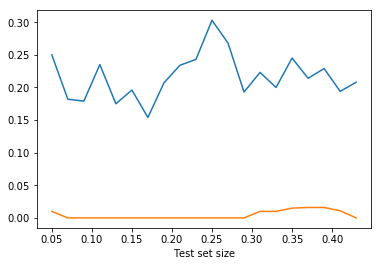

In [25]:
plt.plot(test_ratios, net_results["tr_size"])
plt.plot(test_ratios, net_results["tr_tr_size"])
plt.xlabel("Test set size")
plt.savefig("ada_tr_size.png")

In [26]:
for base in ada_hyperparams["base"]:
    clf = AdaBoostClassifier(base_names[base], random_state=seed, algorithm='SAMME')
    clf = clf.fit(x_tr, y_tr)
    y_pred = clf.predict(x_te)
    ada_results["base"].append(r_err(y_te, y_pred))
    y_tr_pred = clf.predict(x_tr)
    ada_results["tr_base"].append(r_err(y_tr, y_tr_pred))
print(ada_results["base"])

[0.148, 0.18, 0.197]


/home/joel/anaconda2/envs/pyEnv/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/home/joel/anaconda2/envs/pyEnv/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning

In [27]:
ada_results["n"] = []
ada_results["tr_n"] = []
for n in ada_hyperparams["n"]:
    clf = AdaBoostClassifier(random_state=seed, n_estimators=n)
    clf = clf.fit(x_tr, y_tr)
    y_pred = clf.predict(x_te)
    ada_results["n"].append(r_err(y_te, y_pred))
    y_tr_pred = clf.predict(x_tr)
    ada_results["tr_n"].append(r_err(y_tr, y_tr_pred))
print(ada_results["n"])

[0.295, 0.295, 0.246, 0.18, 0.197, 0.18, 0.262, 0.246, 0.23, 0.246, 0.262, 0.262, 0.295, 0.311, 0.311, 0.311, 0.311, 0.311, 0.311, 0.311, 0.328, 0.328, 0.311, 0.311, 0.311, 0.295, 0.295, 0.295, 0.311, 0.311, 0.311, 0.311, 0.311, 0.328, 0.311, 0.295, 0.295, 0.311, 0.311, 0.311, 0.311, 0.311, 0.311, 0.311, 0.311, 0.311, 0.311, 0.295, 0.311, 0.311]


In [28]:
for depth in ada_hyperparams["max_depth"]:
    clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=depth),random_state=seed)
    clf = clf.fit(x_tr, y_tr)
    y_pred = clf.predict(x_te)
    ada_results["max_depth"].append(r_err(y_te, y_pred))
    y_tr_pred = clf.predict(x_tr)
    ada_results["tr_max_depth"].append(r_err(y_tr, y_tr_pred))
print(ada_results["max_depth"])

[0.311, 0.279, 0.23, 0.295]


In [29]:
# SVM: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
from sklearn.svm import SVC
clf = SVC(C=1.0,kernel='rbf',random_state=seed)

accuracy = cross_val_score(clf, x_tr, y_tr, scoring='accuracy', cv=kf)
print(accuracy.mean()) # Easy graph over number of classes here
time_start = datetime.now()
clf = clf.fit(x_tr, y_tr)
print("SVC trained in {}".format(datetime.now() - time_start))
y_pred = clf.predict(x_te)
y_pred = clf.predict(x_te)
print(accuracy_score(y_te, y_pred))

0.8343537414965987
SVC trained in 0:00:00.002306
0.819672131147541


In [30]:
svm_hyperparams = {"C": np.exp(np.arange(11)-5), # https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html
                   "kernel": ["linear", "poly", "sigmoid", "rbf"],
                   "gamma": np.exp(np.arange(11)-5), # https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html
                   "max_iter": np.arange(100) + 1,
                   }
svm_results = {}
for key in svm_hyperparams:
    svm_results[key] = []
    svm_results["tr_{}".format(key)] = []

In [31]:
svm_results["tr_size"] = []
svm_results["tr_tr_size"] = []
clf = SVC()
for splits in split_presets:
    split_x_tr, split_x_te, split_y_tr, split_y_te = splits
    clf = clf.fit(split_x_tr, split_y_tr)
    y_pred = clf.predict(split_x_te)
    svm_results["tr_size"].append(r_err(split_y_te, y_pred))
    y_tr_pred = clf.predict(split_x_tr)
    svm_results["tr_tr_size"].append(r_err(split_y_tr, y_tr_pred))
print(svm_results["tr_size"])

[0.25, 0.273, 0.25, 0.206, 0.175, 0.174, 0.173, 0.172, 0.172, 0.157, 0.158, 0.171, 0.17, 0.181, 0.17, 0.16, 0.196, 0.195, 0.21, 0.185]


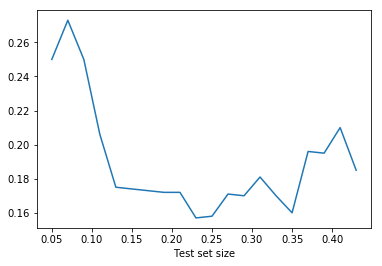

In [32]:
plt.plot(test_ratios, svm_results["tr_size"])
plt.xlabel("Test set size")
plt.savefig("svm_tr_size.png")

In [33]:
for C in svm_hyperparams["C"]:
    clf = SVC(C=C)
    clf = clf.fit(x_tr, y_tr)
    y_pred = clf.predict(x_te)
    svm_results["C"].append(r_err(y_te, y_pred))
    y_tr_pred = clf.predict(x_tr)
    svm_results["tr_C"].append(r_err(y_tr, y_tr_pred))
print(svm_results["C"])

[0.279, 0.279, 0.279, 0.262, 0.148, 0.18, 0.197, 0.23, 0.213, 0.23, 0.246]


In [34]:
for ker in svm_hyperparams["kernel"]:
    clf = SVC(kernel=ker)
    clf = clf.fit(x_tr, y_tr)
    y_pred = clf.predict(x_te)
    svm_results["kernel"].append(r_err(y_te, y_pred))
    y_tr_pred = clf.predict(x_tr)
    svm_results["tr_kernel"].append(r_err(y_tr, y_tr_pred))
print(svm_results["kernel"])

[0.18, 0.213, 0.197, 0.18]


In [35]:
for gamma in svm_hyperparams["gamma"]:
    clf = SVC(gamma=gamma)
    clf = clf.fit(x_tr, y_tr)
    y_pred = clf.predict(x_te)
    svm_results["gamma"].append(r_err(y_te, y_pred))
    y_tr_pred = clf.predict(x_tr)
    svm_results["tr_gamma"].append(r_err(y_tr, y_tr_pred))
print(svm_results["gamma"])

[0.18, 0.18, 0.18, 0.18, 0.262, 0.279, 0.279, 0.279, 0.279, 0.279, 0.279]


In [36]:
"""This is pretty hard to interpet --> ignore"""
for max_iter in svm_hyperparams["max_iter"]:
    clf = SVC(max_iter=max_iter)
    clf = clf.fit(x_tr, y_tr)
    y_pred = clf.predict(x_te)
    svm_results["max_iter"].append(r_err(y_te, y_pred))
    y_tr_pred = clf.predict(x_tr)
    svm_results["tr_max_iter"].append(r_err(y_tr, y_tr_pred))
print(svm_results["max_iter"])

/home/joel/anaconda2/envs/pyEnv/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/joel/anaconda2/envs/pyEnv/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=2).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/joel/anaconda2/envs/pyEnv/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=3).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/joel/anaconda2/envs/pyEnv/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=4).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

[0.279, 0.262, 0.246, 0.23, 0.197, 0.246, 0.279, 0.262, 0.246, 0.164, 0.18, 0.246, 0.18, 0.213, 0.23, 0.197, 0.23, 0.246, 0.23, 0.213, 0.197, 0.262, 0.246, 0.197, 0.23, 0.311, 0.262, 0.23, 0.246, 0.295, 0.213, 0.18, 0.246, 0.246, 0.246, 0.23, 0.23, 0.18, 0.213, 0.197, 0.246, 0.197, 0.197, 0.197, 0.23, 0.23, 0.18, 0.197, 0.197, 0.197, 0.197, 0.213, 0.213, 0.197, 0.197, 0.197, 0.197, 0.197, 0.18, 0.18, 0.18, 0.197, 0.18, 0.18, 0.18, 0.197, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.164, 0.18, 0.18, 0.18, 0.18, 0.164, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18]


/home/joel/anaconda2/envs/pyEnv/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=75).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/joel/anaconda2/envs/pyEnv/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=76).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/joel/anaconda2/envs/pyEnv/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=77).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/joel/anaconda2/envs/pyEnv/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=78).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, 

In [37]:
# KNN: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()

accuracy = cross_val_score(clf, x_tr, y_tr, scoring='accuracy', cv=kf)
print(accuracy.mean()) # Easy graph over number of classes here
time_start = datetime.now()
clf = clf.fit(x_tr, y_tr)
print("KNN trained in {}".format(datetime.now() - time_start))
y_pred = clf.predict(x_te)
y_pred = clf.predict(x_te)
print(accuracy_score(y_te, y_pred))

0.809438775510204
KNN trained in 0:00:00.000672
0.819672131147541


In [38]:
# KNN Hyperparams
knn_hyperparams = {"k": np.arange(10) + 1,
                   "weighting": ['uniform', 'distance'],
                   "p": np.arange(10) + 1}
# Base params: relu, max_iter: 200 (==> convergence), lbfgs (good for smaller datasets), standard alpha
knn_results = {}
for key in knn_hyperparams:
    knn_results[key] = []
    knn_results["tr_{}".format(key)] = []


In [39]:
knn_results["tr_size"] = []
knn_results["tr_tr_size"] = []
clf = KNeighborsClassifier()
for splits in split_presets:
    split_x_tr, split_x_te, split_y_tr, split_y_te = splits
    clf = clf.fit(split_x_tr, split_y_tr)
    y_pred = clf.predict(split_x_te)
    knn_results["tr_size"].append(r_err(split_y_te, y_pred))
    y_tr_pred = clf.predict(split_x_tr)
    knn_results["tr_tr_size"].append(r_err(split_y_tr, y_tr_pred))
print(knn_results["tr_size"])

[0.188, 0.227, 0.214, 0.206, 0.2, 0.196, 0.173, 0.172, 0.188, 0.186, 0.197, 0.22, 0.227, 0.213, 0.21, 0.208, 0.232, 0.237, 0.218, 0.2]


In [40]:
for k in knn_hyperparams["k"]:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf = clf.fit(x_tr, y_tr)
    y_pred = clf.predict(x_te)
    knn_results["k"].append(r_err(y_te, y_pred))
    y_tr_pred = clf.predict(x_tr)
    knn_results["tr_k"].append(r_err(y_tr, y_tr_pred))
print(knn_results["k"])

[0.197, 0.213, 0.197, 0.197, 0.18, 0.164, 0.18, 0.197, 0.18, 0.18]


In [41]:
for weighting in knn_hyperparams["weighting"]:
    clf = KNeighborsClassifier(weights=weighting)
    clf = clf.fit(x_tr, y_tr)
    y_pred = clf.predict(x_te)
    knn_results["weighting"].append(r_err(y_te, y_pred))
    y_tr_pred = clf.predict(x_tr)
    knn_results["tr_weighting"].append(r_err(y_tr, y_tr_pred))
print(knn_results["weighting"]) # Presumably due to dimensionality -> space too sparse

[0.18, 0.18]


In [42]:
print(knn_results["tr_weighting"])

[0.087, 0.0]


In [43]:
for p in knn_hyperparams["p"]:
    clf = KNeighborsClassifier(p=p)
    clf = clf.fit(x_tr, y_tr)
    y_pred = clf.predict(x_te)
    knn_results["p"].append(r_err(y_te, y_pred))
    y_tr_pred = clf.predict(x_tr)
    knn_results["tr_p"].append(r_err(y_tr, y_tr_pred))
print(knn_results["p"])

[0.148, 0.18, 0.197, 0.18, 0.18, 0.18, 0.18, 0.197, 0.18, 0.18]


In [44]:
train_ratios = [1 - ratio for ratio in test_ratios]

In [45]:
from matplotlib.transforms import Bbox

def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels() 
#    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])

    return bbox.expanded(1.0 + pad, 1.0 + pad)


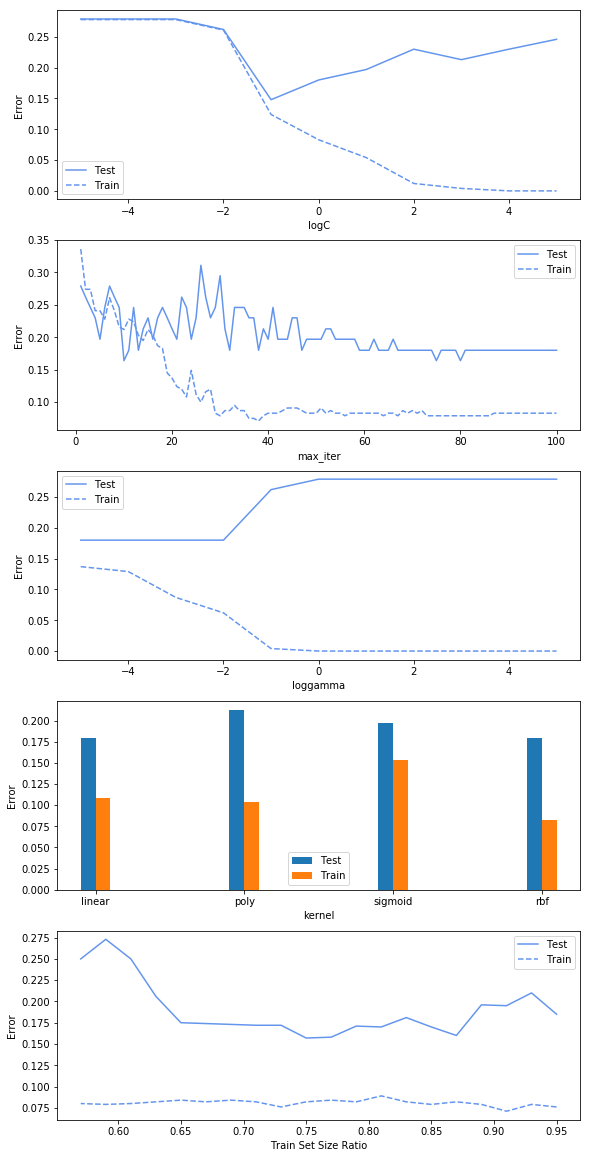

In [46]:
cur_hyperparams = svm_hyperparams
cur_results = svm_results
fig, axes = plt.subplots(len(cur_hyperparams.keys()) + 1, 1, figsize=(8,16))
plt.tight_layout(h_pad=2)
for i, param in enumerate(cur_hyperparams):
    axes[i].set_xlabel(param)
    axes[i].set_ylabel("Error")
    if type(cur_hyperparams[param][0]) is str: # bar graph
        ind = np.arange(len(cur_hyperparams[param]))
        width = .1
        axes[i].set_xticks(ind + width / 2)
        axes[i].set_xticklabels(cur_hyperparams[param])
        axes[i].bar(ind, cur_results[param], width, label="Test")
        axes[i].bar(ind+width, cur_results["tr_{}".format(param)], width, label="Train")
    else:
        x_axis = cur_hyperparams[param]
        if param == 'gamma' or param == 'C':
            x_axis = np.log(x_axis)
            axes[i].set_xlabel('log{}'.format(param))
        axes[i].plot(x_axis, cur_results[param], color="cornflowerblue", linestyle='-', label="Test")
        axes[i].plot(x_axis, cur_results["tr_{}".format(param)], color="cornflowerblue", linestyle='--', label="Train")
    axes[i].legend()
axes[-1].plot(train_ratios, cur_results["tr_size"][::-1], color="cornflowerblue", linestyle='-', label="Test")
axes[-1].plot(train_ratios, cur_results["tr_tr_size"][::-1], color="cornflowerblue", linestyle='--', label="Train")
axes[-1].legend()
axes[-1].set_xlabel("Train Set Size Ratio")
axes[-1].set_ylabel("Error")


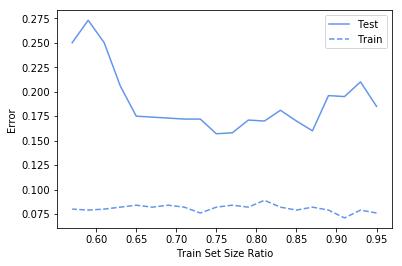

In [47]:
model = "svm"
cur_hyperparams = svm_hyperparams
cur_results = svm_results
for i, param in enumerate(cur_hyperparams):
    plt.xlabel(param)
    plt.ylabel("Error")
    if type(cur_hyperparams[param][0]) is str: # bar graph
        ind = np.arange(len(cur_hyperparams[param]))
        width = .1
        plt.xticks(ind + width / 2, cur_hyperparams[param])
        plt.bar(ind, cur_results[param], width, label="Test")
        plt.bar(ind+width, cur_results["tr_{}".format(param)], width, label="Train")
    else:
        x_axis = cur_hyperparams[param]
        if param == 'gamma' or param == 'C':
            x_axis = np.log(x_axis)
            plt.xlabel('log{}'.format(param))
        plt.plot(x_axis, cur_results[param], color="cornflowerblue", linestyle='-', label="Test")
        plt.plot(x_axis, cur_results["tr_{}".format(param)], color="cornflowerblue", linestyle='--', label="Train")
    plt.legend()
    plt.savefig("figures/{}_{}_{}.png".format(dset, model, param))
    plt.clf()
plt.plot(train_ratios, cur_results["tr_size"][::-1], color="cornflowerblue", linestyle='-', label="Test")
plt.plot(train_ratios, cur_results["tr_tr_size"][::-1], color="cornflowerblue", linestyle='--', label="Train")
plt.legend()
plt.xlabel("Train Set Size Ratio")
plt.ylabel("Error")
plt.savefig("figures/{}_{}_tr.png".format(dset, model))


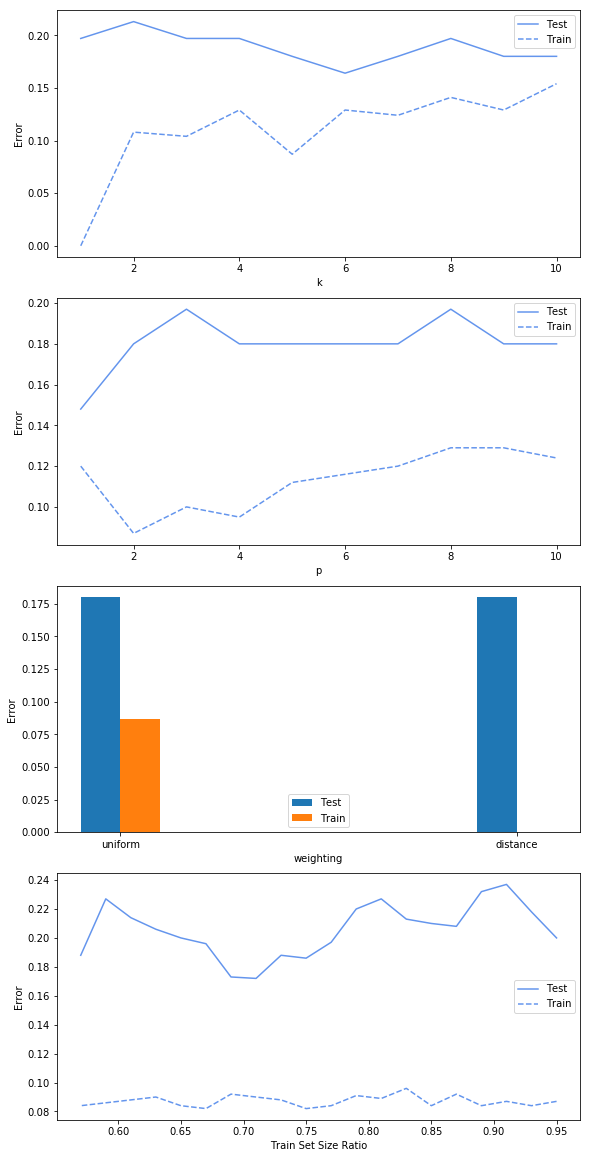

In [48]:
cur_hyperparams = knn_hyperparams
cur_results = knn_results
fig, axes = plt.subplots(len(cur_hyperparams.keys()) + 1, 1, figsize=(8,16))
plt.tight_layout(h_pad=2)
for i, param in enumerate(cur_hyperparams):
    if type(cur_hyperparams[param][0]) is str: # bar graph
        ind = np.arange(len(cur_hyperparams[param]))
        width = .1
        axes[i].set_xticks(ind + width / 2)
        axes[i].set_xticklabels(cur_hyperparams[param])
        axes[i].bar(ind, cur_results[param], width, label="Test")
        axes[i].bar(ind+width, cur_results["tr_{}".format(param)], width, label="Train")
    else:
        axes[i].plot(cur_hyperparams[param], cur_results[param], color="cornflowerblue", linestyle='-', label="Test")
        axes[i].plot(cur_hyperparams[param], cur_results["tr_{}".format(param)], color="cornflowerblue", linestyle='--', label="Train")
    axes[i].legend()
    axes[i].set_xlabel(param)
    axes[i].set_ylabel("Error")
axes[-1].plot(train_ratios, cur_results["tr_size"][::-1], color="cornflowerblue", linestyle='-', label="Test")
axes[-1].plot(train_ratios, cur_results["tr_tr_size"][::-1], color="cornflowerblue", linestyle='--', label="Train")
axes[-1].legend()
axes[-1].set_xlabel("Train Set Size Ratio")
axes[-1].set_ylabel("Error")

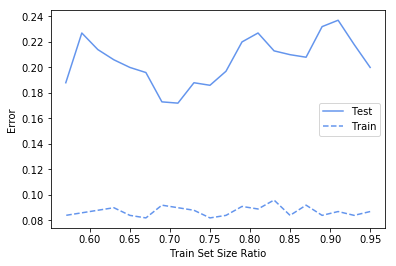

In [49]:
model = "knn"
cur_hyperparams = knn_hyperparams
cur_results = knn_results
for i, param in enumerate(cur_hyperparams):
    if type(cur_hyperparams[param][0]) is str: # bar graph
        ind = np.arange(len(cur_hyperparams[param]))
        width = .1
        plt.xticks(ind + width / 2, cur_hyperparams[param])
        plt.bar(ind, cur_results[param], width, label="Test")
        plt.bar(ind+width, cur_results["tr_{}".format(param)], width, label="Train")
    else:
        plt.plot(cur_hyperparams[param], cur_results[param], color="cornflowerblue", linestyle='-', label="Test")
        plt.plot(cur_hyperparams[param], cur_results["tr_{}".format(param)], color="cornflowerblue", linestyle='--', label="Train")
    plt.legend()
    plt.xlabel(param)
    plt.ylabel("Error")
    plt.savefig("figures/{}_{}_{}.png".format(dset, model, param))
    plt.clf()
plt.plot(train_ratios, cur_results["tr_size"][::-1], color="cornflowerblue", linestyle='-', label="Test")
plt.plot(train_ratios, cur_results["tr_tr_size"][::-1], color="cornflowerblue", linestyle='--', label="Train")
plt.legend()
plt.xlabel("Train Set Size Ratio")
plt.ylabel("Error")
plt.savefig("figures/{}_{}_tr.png".format(dset, model))


base
n
max_depth


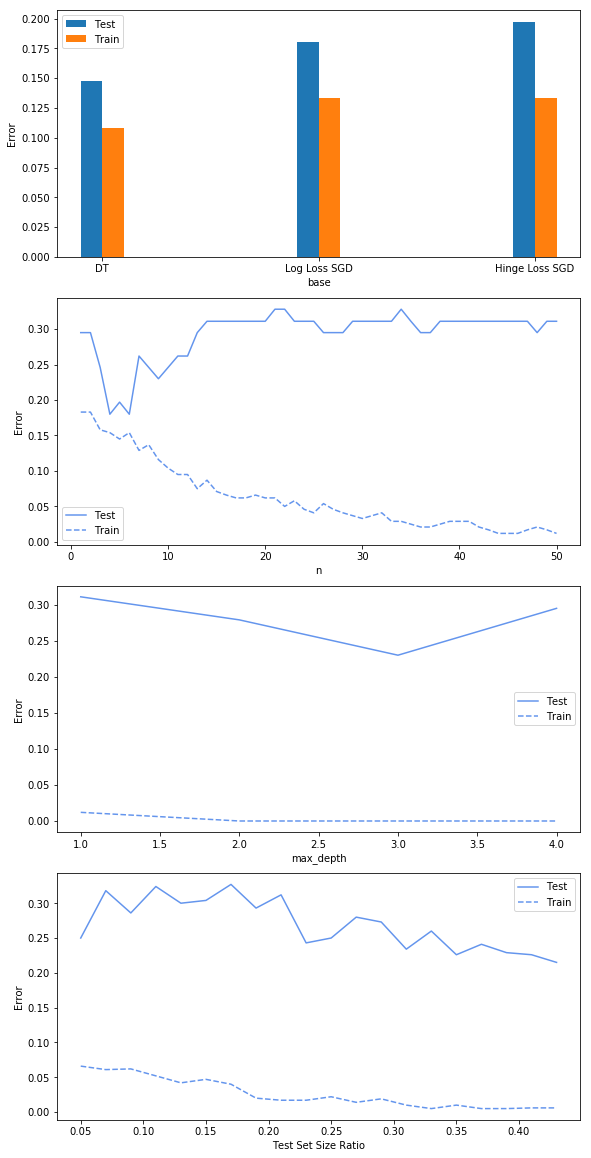

In [50]:
cur_hyperparams = ada_hyperparams
cur_results = ada_results
fig, axes = plt.subplots(len(cur_hyperparams.keys()) + 1, 1, figsize=(8,16))
plt.tight_layout(h_pad=2)
for i, param in enumerate(cur_hyperparams):
    print(param)
    if type(cur_hyperparams[param][0]) is str: # bar graph
        ind = np.arange(len(cur_hyperparams[param]))
        width = .1
        axes[i].set_xticks(ind + width / 2)
        axes[i].set_xticklabels(cur_hyperparams[param])
        axes[i].bar(ind, cur_results[param], width, label="Test")
        axes[i].bar(ind+width, cur_results["tr_{}".format(param)], width, label="Train")
    else:
        axes[i].plot(cur_hyperparams[param], cur_results[param], color="cornflowerblue", linestyle='-', label="Test")
        axes[i].plot(cur_hyperparams[param], cur_results["tr_{}".format(param)], color="cornflowerblue", linestyle='--', label="Train")
    axes[i].legend()
    axes[i].set_xlabel(param)
    axes[i].set_ylabel("Error")
axes[-1].plot(test_ratios, cur_results["tr_size"], color="cornflowerblue", linestyle='-', label="Test")
axes[-1].plot(test_ratios, cur_results["tr_tr_size"], color="cornflowerblue", linestyle='--', label="Train")
axes[-1].legend()
axes[-1].set_xlabel("Test Set Size Ratio")
axes[-1].set_ylabel("Error")

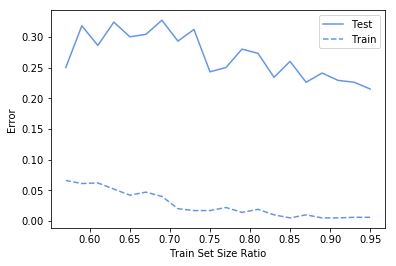

In [51]:
model = "ada"
cur_hyperparams = ada_hyperparams
cur_results = ada_results
for i, param in enumerate(cur_hyperparams):
    if type(cur_hyperparams[param][0]) is str: # bar graph
        ind = np.arange(len(cur_hyperparams[param]))
        width = .1
        plt.xticks(ind + width / 2, cur_hyperparams[param])
        plt.bar(ind, cur_results[param], width, label="Test")
        plt.bar(ind+width, cur_results["tr_{}".format(param)], width, label="Train")
    else:
        plt.plot(cur_hyperparams[param], cur_results[param], color="cornflowerblue", linestyle='-', label="Test")
        plt.plot(cur_hyperparams[param], cur_results["tr_{}".format(param)], color="cornflowerblue", linestyle='--', label="Train")
    plt.legend()
    plt.xlabel(param)
    plt.ylabel("Error")
    plt.savefig("figures/{}_{}_{}.png".format(dset, model, param))
    plt.clf()
plt.plot(train_ratios, cur_results["tr_size"][::-1], color="cornflowerblue", linestyle='-', label="Test")
plt.plot(train_ratios, cur_results["tr_tr_size"][::-1], color="cornflowerblue", linestyle='--', label="Train")
plt.legend()
plt.xlabel("Train Set Size Ratio")
plt.ylabel("Error")
plt.savefig("figures/{}_{}_tr.png".format(dset, model))


max_leaf_nodes
90
90
criterion
2
2
max_depth
29
29
min_weight_fraction
20
20


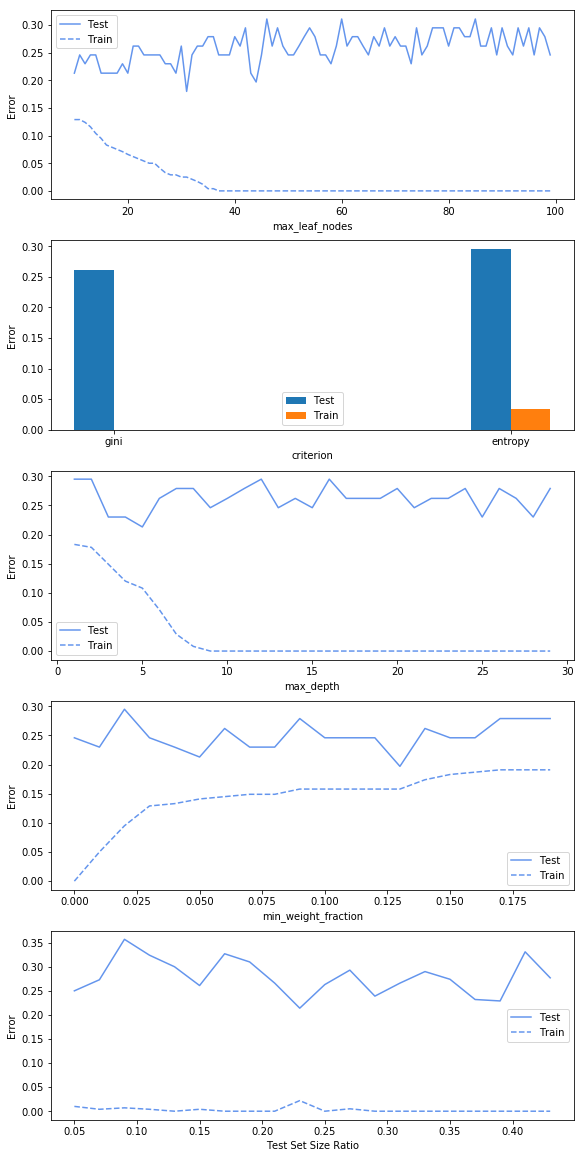

In [52]:
cur_hyperparams = dt_hyperparams
cur_results = dt_results
fig, axes = plt.subplots(len(cur_hyperparams.keys()) + 1, 1, figsize=(8,16))
plt.tight_layout(h_pad=2)
for i, param in enumerate(cur_hyperparams):
    print(param)
    print(len(cur_hyperparams[param]))
    print(len(cur_results[param]))
    if type(cur_hyperparams[param][0]) is str: # bar graph
        ind = np.arange(len(cur_hyperparams[param]))
        width = .1
        axes[i].set_xticks(ind + width / 2)
        axes[i].set_xticklabels(cur_hyperparams[param])
        axes[i].bar(ind, cur_results[param], width, label="Test")
        axes[i].bar(ind+width, cur_results["tr_{}".format(param)], width, label="Train")
    else:
        axes[i].plot(cur_hyperparams[param], cur_results[param], color="cornflowerblue", linestyle='-', label="Test")
        axes[i].plot(cur_hyperparams[param], cur_results["tr_{}".format(param)], color="cornflowerblue", linestyle='--', label="Train")
    axes[i].legend()
    axes[i].set_xlabel(param)
    axes[i].set_ylabel("Error")
axes[-1].plot(test_ratios, cur_results["tr_size"], color="cornflowerblue", linestyle='-', label="Test")
axes[-1].plot(test_ratios, cur_results["tr_tr_size"], color="cornflowerblue", linestyle='--', label="Train")
axes[-1].legend()
axes[-1].set_xlabel("Test Set Size Ratio")
axes[-1].set_ylabel("Error")

for i, param in enumerate(cur_hyperparams):
    extent = full_extent(axes[i]).transformed(fig.dpi_scale_trans.inverted())
    fig.savefig("diabetes_dt_{}.png".format(param), bbox_inches=extent)
extent = full_extent(axes[-1]).transformed(fig.dpi_scale_trans.inverted())
fig.savefig("diabetes_dt_tr.png", bbox_inches=extent)


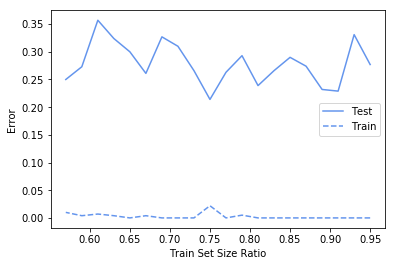

In [53]:
model = "dt"
cur_hyperparams = dt_hyperparams
cur_results = dt_results
for i, param in enumerate(cur_hyperparams):
    if type(cur_hyperparams[param][0]) is str: # bar graph
        ind = np.arange(len(cur_hyperparams[param]))
        width = .1
        plt.xticks(ind + width / 2, cur_hyperparams[param])
        plt.bar(ind, cur_results[param], width, label="Test")
        plt.bar(ind+width, cur_results["tr_{}".format(param)], width, label="Train")
    else:
        plt.plot(cur_hyperparams[param], cur_results[param], color="cornflowerblue", linestyle='-', label="Test")
        plt.plot(cur_hyperparams[param], cur_results["tr_{}".format(param)], color="cornflowerblue", linestyle='--', label="Train")
    plt.legend()
    plt.xlabel(param)
    plt.ylabel("Error")
    plt.savefig("figures/{}_{}_{}.png".format(dset, model, param))
    plt.clf()
plt.plot(train_ratios, cur_results["tr_size"][::-1], color="cornflowerblue", linestyle='-', label="Test")
plt.plot(train_ratios, cur_results["tr_tr_size"][::-1], color="cornflowerblue", linestyle='--', label="Train")
plt.legend()
plt.xlabel("Train Set Size Ratio")
plt.ylabel("Error")
plt.savefig("figures/{}_{}_tr.png".format(dset, model))


epochs
activation
arch2
arch1
alpha
arch3


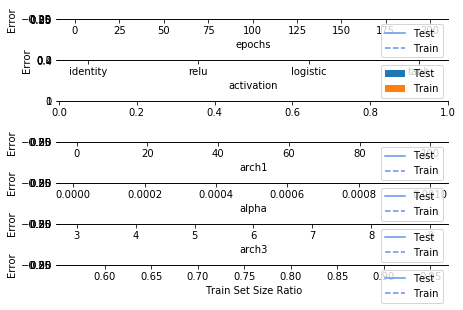

In [54]:
cur_hyperparams = net_hyperparams
cur_results = net_results
fig, axes = plt.subplots(len(cur_hyperparams.keys()) + 1, 1)
plt.tight_layout(h_pad=2)
arch2_i = 0
cur_hyperparams["arch1"][0] = 0
for i, param in enumerate(cur_hyperparams):
    print(param)
    if param == "arch2":
        arch2_i = i
        continue
    if type(cur_hyperparams[param][0]) is str: # bar graph
        ind = np.arange(len(cur_hyperparams[param]))
        width = .1
        axes[i].set_xticks(ind + width / 2)
        axes[i].set_xticklabels(cur_hyperparams[param])
        axes[i].bar(ind, cur_results[param], width, label="Test")
        axes[i].bar(ind+width, cur_results["tr_{}".format(param)], width, label="Train")
    else:
        if param == 'arch3':
            x_axis = list(map(lambda li: len(li), cur_hyperparams[param]))
            axes[i].plot(x_axis, cur_results[param], color="cornflowerblue", linestyle='-', label="Test")
            axes[i].plot(x_axis, cur_results["tr_{}".format(param)], color="cornflowerblue", linestyle='--', label="Train")
        else:
            axes[i].plot(cur_hyperparams[param], cur_results[param], color="cornflowerblue", linestyle='-', label="Test")
            axes[i].plot(cur_hyperparams[param], cur_results["tr_{}".format(param)], color="cornflowerblue", linestyle='--', label="Train")
    axes[i].legend()
    axes[i].set_xlabel(param)
    axes[i].set_ylabel("Error")
axes[-1].plot(train_ratios, cur_results["tr_size"][::-1], color="cornflowerblue", linestyle='-', label="Test")
axes[-1].plot(train_ratios, cur_results["tr_tr_size"][::-1], color="cornflowerblue", linestyle='--', label="Train")
axes[-1].legend()
axes[-1].set_xlabel("Train Set Size Ratio")
axes[-1].set_ylabel("Error")

In [55]:
model = "net"
cur_hyperparams = net_hyperparams
cur_results = net_results
fig, axes = plt.subplots(len(cur_hyperparams.keys()) + 1, 1)
plt.tight_layout(h_pad=2)
arch2_i = 0
cur_hyperparams["arch1"][0] = 0
for i, param in enumerate(cur_hyperparams):
    plt.xlabel(param)
    if param == 'arch1':
        plt.xlabel("1 n-node hidden layer")
    plt.ylabel("Error")
    if param == "arch2":
        arch2_i = i
        continue
    if type(cur_hyperparams[param][0]) is str: # bar graph
        ind = np.arange(len(cur_hyperparams[param]))
        width = .1
        plt.xticks(ind + width / 2, cur_hyperparams[param])
        plt.bar(ind, cur_results[param], width, label="Test")
        plt.bar(ind+width, cur_results["tr_{}".format(param)], width, label="Train")
    else:
        if param == 'arch3':
            plt.clf()
            plt.ylabel("Error") # dunno what's up with this
            plt.xlabel("n 10-node hidden layers")
            x_axis = list(map(lambda li: len(li), cur_hyperparams[param]))
            print(x_axis)
            print(cur_results[param])
            print(cur_results["tr_arch3"])
            plt.plot(x_axis, cur_results[param], color="cornflowerblue", linestyle='-', label="Test")
            plt.plot(x_axis, cur_results["tr_{}".format(param)], color="cornflowerblue", linestyle='--', label="Train")
        else:
            plt.plot(cur_hyperparams[param], cur_results[param], color="cornflowerblue", linestyle='-', label="Test")
            plt.plot(cur_hyperparams[param], cur_results["tr_{}".format(param)], color="cornflowerblue", linestyle='--', label="Train")
    plt.legend()
    plt.savefig("figures/{}_{}_{}.png".format(dset, model, param), bbox_inches='tight')
    plt.clf()
plt.plot(train_ratios, cur_results["tr_size"][::-1], color="cornflowerblue", linestyle='-', label="Test")
plt.plot(train_ratios, cur_results["tr_tr_size"][::-1], color="cornflowerblue", linestyle='--', label="Train")
plt.legend()
plt.xlabel("Train Set Size Ratio")
plt.ylabel("Error")
plt.savefig("figures/{}_{}_tr.png".format(dset, model))
plt.clf()


[3, 4, 5, 6, 7, 8, 9]
[0.18, 0.295, 0.213, 0.18, 0.23, 0.197, 0.197]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.083, 0.021]


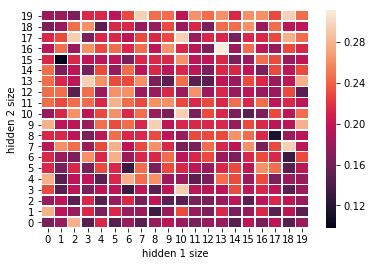

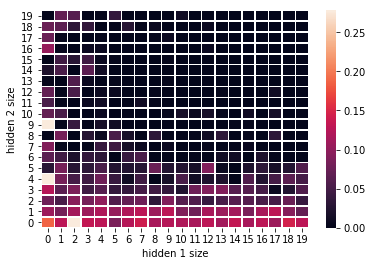

In [56]:
import seaborn as sns
cur_results["arch2"] = np.asarray(cur_results["arch2"]).reshape(20, 20)
ax = sns.heatmap(cur_results['arch2'], linewidth=0.5)
ax.invert_yaxis()
ax.set(xlabel='hidden 1 size', ylabel='hidden 2 size')
# plt.imshow(cur_results["arch2"], cmap='hot', interpolation='nearest')
fig = ax.get_figure()
plt.show()
fig.savefig("figures/{}_net_arch2.png".format(dset))
plt.clf()
cur_results["tr_arch2"] = np.asarray(cur_results["tr_arch2"]).reshape(20, 20)
ax = sns.heatmap(cur_results['tr_arch2'], linewidth=0.5)
ax.invert_yaxis()
ax.set(xlabel='hidden 1 size', ylabel='hidden 2 size')
fig = ax.get_figure()
# plt.imshow(cur_results["arch2"], cmap='hot', interpolation='nearest')
plt.show()
fig.savefig("figures/{}_net_arch2_tr.png".format(dset))
plt.clf()

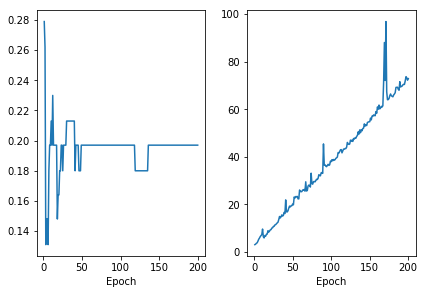

In [57]:
fig, axes = plt.subplots(1, 2)
plt.tight_layout()
axes[0].plot(net_hyperparams["epochs"], net_results["epochs"])
axes[1].plot(net_hyperparams["epochs"], net_results["epochs_time"])
axes[0].set_xlabel("Epoch")
axes[1].set_xlabel("Epoch")

In [58]:
# Best hyperparams learning curves
def get_results(clf):
    cv_arr = np.zeros((len(split_presets_all), len(split_presets_all[0])))
    tr_cv_arr = np.zeros((len(split_presets_all), len(split_presets_all[0])))
    for i, split_preset in enumerate(split_presets_all):
        for j, splits in enumerate(split_preset):
            split_x_tr, split_x_te, split_y_tr, split_y_te = splits
            clf = clf.fit(split_x_tr, split_y_tr)
            y_pred = clf.predict(split_x_te)
            cv_arr[i, j] = r_err(split_y_te, y_pred)
            y_tr_pred = clf.predict(split_x_tr)
            tr_cv_arr[i, j] = r_err(split_y_tr, y_tr_pred)
    return np.mean(cv_arr, axis=0), np.mean(tr_cv_arr, axis=0) 

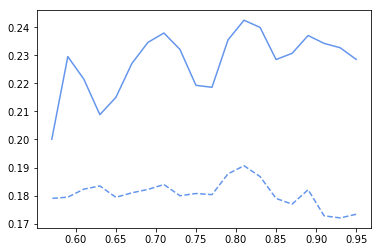

In [110]:
clf = DecisionTreeClassifier(max_leaf_nodes=3, random_state=seed)
dt_results["final_tr_size"], dt_results["final_tr_tr_size"] = get_results(clf)
plt.plot(train_ratios, dt_results["final_tr_size"][::-1], linestyle='-', color='cornflowerblue')
plt.plot(train_ratios, dt_results["final_tr_tr_size"][::-1], linestyle='--', color='cornflowerblue')
plt.savefig('figures/{}_dt_tr.png'.format(dset))

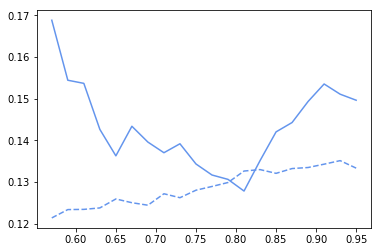

In [111]:
clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(3, 3), alpha=12, random_state=seed)
net_results["final_tr_size"], net_results["final_tr_tr_size"] = get_results(clf)
plt.plot(train_ratios, net_results["final_tr_size"][::-1], linestyle='-', color='cornflowerblue')
plt.plot(train_ratios, net_results["final_tr_tr_size"][::-1], linestyle='--', color='cornflowerblue')
plt.savefig('figures/{}_net_tr.png'.format(dset))

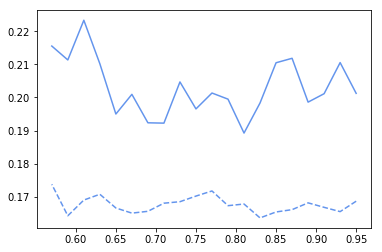

In [112]:
clf = AdaBoostClassifier(n_estimators=4, algorithm='SAMME', random_state=seed)
ada_results["final_tr_size"], ada_results["final_tr_tr_size"] = get_results(clf)
plt.plot(train_ratios, ada_results["final_tr_size"][::-1], linestyle='-', color='cornflowerblue')
plt.plot(train_ratios, ada_results["final_tr_tr_size"][::-1], linestyle='--', color='cornflowerblue')
plt.savefig('figures/{}_ada_tr.png'.format(dset))

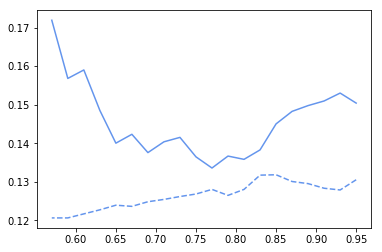

In [113]:
clf = SVC(C=np.exp(0), gamma=np.exp(-4))
svm_results["final_tr_size"], svm_results["final_tr_tr_size"] = get_results(clf)
plt.plot(train_ratios, svm_results["final_tr_size"][::-1], linestyle='-', color='cornflowerblue')
plt.plot(train_ratios, svm_results["final_tr_tr_size"][::-1], linestyle='--', color='cornflowerblue')
plt.savefig('figures/{}_svm_tr.png'.format(dset))

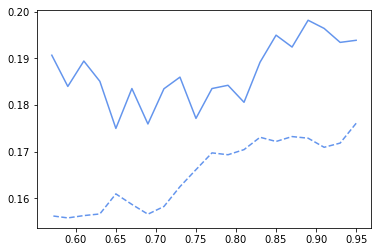

In [114]:
clf = KNeighborsClassifier(n_neighbors=12)
knn_results["final_tr_size"], knn_results["final_tr_tr_size"] = get_results(clf)
plt.plot(train_ratios, knn_results["final_tr_size"][::-1], linestyle='-', color='cornflowerblue')
plt.plot(train_ratios, knn_results["final_tr_tr_size"][::-1], linestyle='--', color='cornflowerblue')
plt.savefig('figures/{}_knn_tr.png'.format(dset))

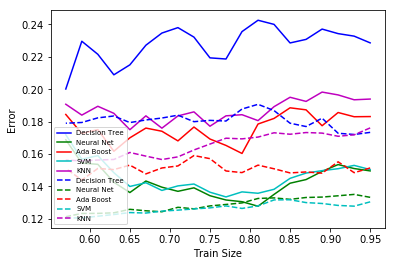

In [94]:
plt.plot(train_ratios, dt_results["final_tr_size"][::-1], linestyle='-', color='b', label="Decision Tree")
plt.plot(train_ratios, net_results["final_tr_size"][::-1], linestyle='-', color='g', label="Neural Net")
plt.plot(train_ratios, ada_results["final_tr_size"][::-1], linestyle='-', color='r', label="Ada Boost")
plt.plot(train_ratios, svm_results["final_tr_size"][::-1], linestyle='-', color='c', label="SVM")
plt.plot(train_ratios, knn_results["final_tr_size"][::-1], linestyle='-', color='m', label="KNN")

plt.plot(train_ratios, dt_results["final_tr_tr_size"][::-1], linestyle='--', color='b', label="Decision Tree")
plt.plot(train_ratios, net_results["final_tr_tr_size"][::-1], linestyle='--', color='g', label="Neural Net")
plt.plot(train_ratios, ada_results["final_tr_tr_size"][::-1], linestyle='--', color='r', label="Ada Boost")
plt.plot(train_ratios, svm_results["final_tr_tr_size"][::-1], linestyle='--', color='c', label="SVM")
plt.plot(train_ratios, knn_results["final_tr_tr_size"][::-1], linestyle='--', color='m', label="KNN")

plt.legend(loc=3, prop={'size':7})
plt.xlabel("Train Size")
plt.ylabel("Error")
plt.savefig('figures/heart_overall.png')